# Simulating Icebergs
This notebook runs and analyzes a series of simulations to evaluate the efficacy of Cuthbert's and BBC's methods for estimating population sizes given a series of samples.

In [1]:
# Libraries
from random_simulation import random_simulation
import pandas as pd
import numpy as np
from plotnine import *
import sklearn as sk

We are dealing with a hypothetical population of 10000 entities, from which a series of uniformly sized samples will be taken and estimates generated. Specifically, we are interested in the population size, the number of distinct entities observed in the samples, the *uncorrected* estimate with Cuthbert's method, and the BBC estimate. Correction via cross-validation is not necessary for Cuthbert's method since this is designed to test assumptions of randomness that the algorithm in fact implements.

In [2]:
sim = random_simulation(10000, num_samples=100, sample_size=100, cuthbert_cv=False)
print('Population size: {}\nEntities observed: {}\nCuthbert Estimate: {}\nBBC Estimate: {:.0f}'.format(
    sim['pop_size'], sim['n_sampled'], sim['cuthbert_est']['uncorrected'], sim['bbc_est']))

Population size: 10000
Entities observed: 6364
Cuthbert Estimate: 10093
BBC Estimate: 8300


You can probably already see where this is going. But let's give these methods a fair shot, and set up a loop that will run a large number of scenarios and record results that we can exmamine.

In [3]:
# Set simulation parameters; 20 combinations simulated 20 times each gives us a nice corpus of
# 400 simulations for each method.
pop_sizes = [10000]
sample_nums = [20, 50, 100, 150, 250]
sample_sizes = [10, 25, 50, 100]
SIMS_PER_CONDITION = 20

# Initialize capta storage devices
sims = {'pop_size': [], 'num_samples': [], 'sample_sizes': [], 'n_sampled': [], 'est_type': [], 'pop_est': []}

# Set up loop, record results
for p_size in pop_sizes:
    for num in sample_nums:
        for s_size in sample_sizes:
            for i in range(SIMS_PER_CONDITION):
                sim = random_simulation(p_size, num_samples = num, sample_size = s_size, cuthbert_cv=False)
                ests = {'cuthbert': sim['cuthbert_est']['uncorrected'], 'bbc': sim['bbc_est']}
                for label in ests.keys():
                    sims['pop_size'].append(p_size)
                    sims['num_samples'].append(num)
                    sims['sample_sizes'].append(s_size)
                    sims['n_sampled'].append(sim['n_sampled'])
                    sims['est_type'].append(label)
                    sims['pop_est'].append(ests[label])
                '''
                if i%5 == 4:
                    print("Completed loop {} with {} samples of size {}".format(i+1, num, s_size))
                '''
simulations = pd.DataFrame(sims)
simulations.head()

,pop_size,num_samples,sample_sizes,n_sampled,est_type,pop_est
0,10000,20,10,200,cuthbert,19999.000000
1,10000,20,10,200,bbc,280.200101
2,10000,20,10,199,cuthbert,18940.000000
3,10000,20,10,199,bbc,278.588486
4,10000,20,10,198,cuthbert,9440.000000


Let's compare their performance now, examining the means and variances of the population estimates within each group.

In [4]:
sim_variance = simulations.groupby(['est_type', 'sample_sizes', 'num_samples']).pop_est.agg([np.mean, np.var])
sim_variance

mean           var
est_type sample_sizes num_samples                            
bbc      10           20             277.707038  4.767882e+00
                      50             679.895279  2.552601e+01
                      100           1322.922186  6.789751e+01
                      150           1933.908953  2.184865e+02
                      250           3036.672863  4.459178e+02
         25           20             683.187337  3.154634e+01
                      50            1634.702265  1.314463e+02
                      100           3043.600726  6.647951e+02
                      150           4266.357034  5.884423e+02
                      250           6216.348493  8.915358e+02
         50           20            1328.310669  1.186697e+02
                      50            3046.784083  2.882622e+02
                      100           5332.848729  1.230792e+03
                      150           7005.363354  1.667649e+03
                      250           9163.009321  2.389185e+03
         100          20            2511.676825  5.308175e+02
                      50            5330.281247  9.954737e+02
                      100           8255.839890  2.017113e+03
                      150           9819.879098  1.255356e+03
                      250          11027.716074  1.299438e+03
cuthbert 10           20           13773.900000  3.674426e+07
                      50            9915.550000  5.159771e+06
                      100           9967.400000  1.259836e+06
                      150          10282.800000  8.666994e+05
                      250           9870.800000  2.283364e+05
         25           20           12254.650000  2.527467e+07
                      50           10244.900000  1.062180e+06
                      100           9988.050000  3.708563e+05
                      150          10016.250000  8.088241e+04
                      250           9966.000000  2.163168e+04
         50           20           10466.950000  3.563189e+06
                      50            9954.650000  1.627511e+05
                      100          10072.400000  6.347499e+04
                      150           9985.200000  2.297922e+04
                      250          10006.100000  8.807463e+03
         100          20            9945.900000  6.788202e+05
                      50            9968.000000  5.002842e+04
                      100           9974.800000  1.242922e+04
                      150           9985.200000  2.893011e+03
                      250           9989.700000  1.109484e+03

And here it is. Not great performance from BBC's method. The estimates very troublingly seem to depend on both the number of samples taken and the sample size, and the variance of those estimates seems to increase concomitantly. On the other hand, Cuthbert's method seems to produce estimates that roughly center on the true population size (10000) for all numbers of all samples. Moreover, both the accuracy and variance of the estimates decreases with the number of samples and sample size. Since these inputs will necessarily be correlated with the total number of distinct entities observed within each simulation, we can simplify this insight by plotting those two quantities against one another.

/Users/wwatson/Desktop/SideProjects/PyCharmVEnv/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 5 x 5 in image.
  from_inches(height, units), units), PlotnineWarning)
/Users/wwatson/Desktop/SideProjects/PyCharmVEnv/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/wwatson/Desktop/Modeling Icebergs/Cuth_BBC_Figure.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


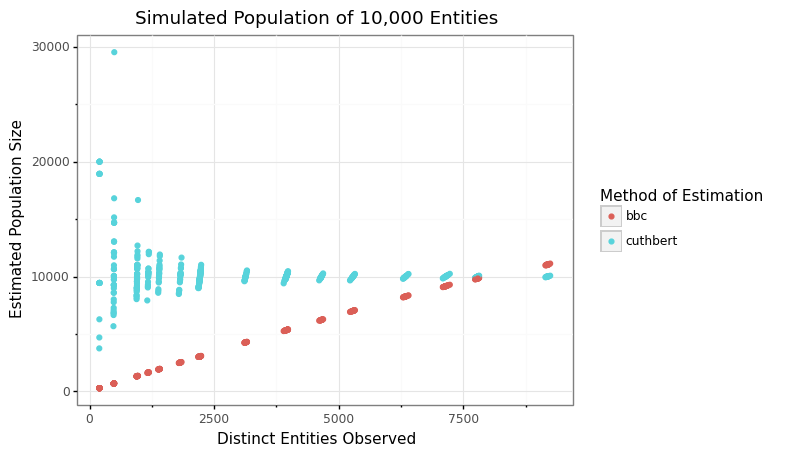

<ggplot: (303550701)>

In [5]:
plot = ggplot(data = simulations)
plot += geom_point(aes(x = 'n_sampled', y = 'pop_est', color = 'est_type'))
plot += labs(x = "Distinct Entities Observed", y = "Estimated Population Size", color = "Method of Estimation")
plot += ggtitle("Simulated Population of 10,000 Entities") 
plot += theme_bw()
#plot.save(filename='/Users/wwatson/Desktop/Modeling Icebergs/Cuth_BBC_Figure.png', width=5, height=5)
plot

Oof. Not only do BBC's estimates of population size grow with the number of entities observed, they do so pretty much linearly. If we had any doubts about the superiority of Cuthbert's method, this should quash them. But BBC's method deserves a little more scrutiny. Let's examine its linear growth a little more carefully.

In [6]:
bbc_simulations = simulations[simulations.est_type.eq('bbc')]
bbc_X = bbc_simulations.n_sampled
bbc_X = bbc_X.values.reshape(-1, 1)
bbc_y = bbc_simulations.pop_est
lm = sk.linear_model.LinearRegression()
lm.fit(bbc_X, bbc_y)
print("The regressed linear model is: pop_est = {:.4f}*n_sampled + {:.4f}".format(lm.coef_[0], lm.intercept_))
print("The R^2 value is: {:.4f}".format(lm.score(bbc_X, bbc_y)))

The regressed linear model is: pop_est = 1.2391*n_sampled + 237.4916
The R^2 value is: 0.9966


R^2 values that high don't come along too often. This also gives us a way to calculate when BBC's estimates would be likely to yield the true population size.

In [7]:
breakeven = 100 * (pop_sizes[0] - lm.intercept_) / (lm.coef_[0] * pop_sizes[0])
print("BBC's method will return the true population size when {:4.2f}% of the population is sampled.".format(breakeven))

BBC's method will return the true population size when 78.79% of the population is sampled.


Another way of saying this is that BBC's method will, on average, tend to indicate that about 78% of any population is represented within the samples we have. This is, to say the least, an undesirable outcome.